## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [3]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [232]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, HoltWinters
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse, rel_mse, mqloss
from hierarchicalforecast.methods import TopDown, BottomUp, MinTrace, OptimalCombination
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

import pickle
from datetime import date, datetime
from sklearn.metrics import mean_absolute_percentage_error
from qgridnext import show_grid
from importlib import reload
import re
import pickle

In [2]:
TEST_PERIODS = 2

In [3]:
Y_df_load = (
    pd.read_parquet("test_train_data.parquet").reset_index()
)
 
Y_df_load["y"] = (
    Y_df_load["y"] / 1e6
)  # make everything in millions so its easier to read

## Prep Data

In [4]:
# last date
last_date = pd.to_datetime(date(2024, 9, 30))

In [5]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [6]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [7]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [8]:
# Get rid of companies for which we do not have enough data
MINIMUM_NUMBER_OF_OBSERVATIONS = 40
Y_df_load = Y_df_load.groupby("ticker").filter(
    lambda x: x.shape[0] > MINIMUM_NUMBER_OF_OBSERVATIONS
)

In [9]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [10]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [11]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [187]:
Y_df_load["market"] = "market"

In [188]:
Y_df_load

,ds,ticker,top_level_SIC_code,second_level_SIC_code,third_level_SIC_code,fourth_level_SIC_code,y,entity_type,market
0,2010-03-31,A,3,8,2,6,1213.000,company,market
1,2010-06-30,A,3,8,2,6,1271.000,company,market
2,2010-09-30,A,3,8,2,6,1384.000,company,market
3,2010-12-31,A,3,8,2,6,1576.000,company,market
4,2011-03-31,A,3,8,2,6,1519.000,company,market
...,...,...,...,...,...,...,...,...,...
155932,2023-09-30,ax,6,0,3,5,84.298,company,market
155933,2023-12-31,ax,6,0,3,5,83.649,company,market
155934,2024-03-31,ax,6,0,3,5,106.767,company,market
155935,2024-06-30,ax,6,0,3,5,294.769,company,market


## Build training data

In [189]:
levels = [
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]


levels = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "ticker"],
]

levels = [
    ["market"],
    ["market", "top_level_SIC_code"],
    ["market", "top_level_SIC_code", "second_level_SIC_code"],
    ["market", "top_level_SIC_code", "second_level_SIC_code", "ticker"],
]

In [190]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=levels)

In [27]:
S_df.to_parquet('S_df.parquet')

In [197]:
S_df.T.iloc[0:20,0:20]

,market,market/0,market/1,market/2,market/3,market/4,market/5,market/6,market/7,market/8,market/0/1,market/0/2,market/0/7,market/1/0,market/1/2,market/1/3,market/1/4,market/1/5,market/1/6,market/1/7
market/0/1/ALCO,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/1/CTVA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/1/LMNR,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/1/RKDA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/1/YTEN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/2/CALM,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/7/CEAD,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/7/CVAT,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/7/CVGW,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
market/0/7/GGROU,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
with open('tags.pickle', 'wb') as out:
    pickle.dump(tags, out)

In [198]:
Y_df = Y_df.reset_index()

In [199]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [200]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4)], freq="QE", n_jobs=-1) 

In [201]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [202]:
Y_hat_df.to_parquet('Y_hat_df.parquet')

In [203]:
Y_fitted_df = fcst.forecast_fitted_values()

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [206]:
show_grid(Y_fitted_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [26]:
Y_fitted_df.to_parquet('Y_fitted_df.parquet')

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


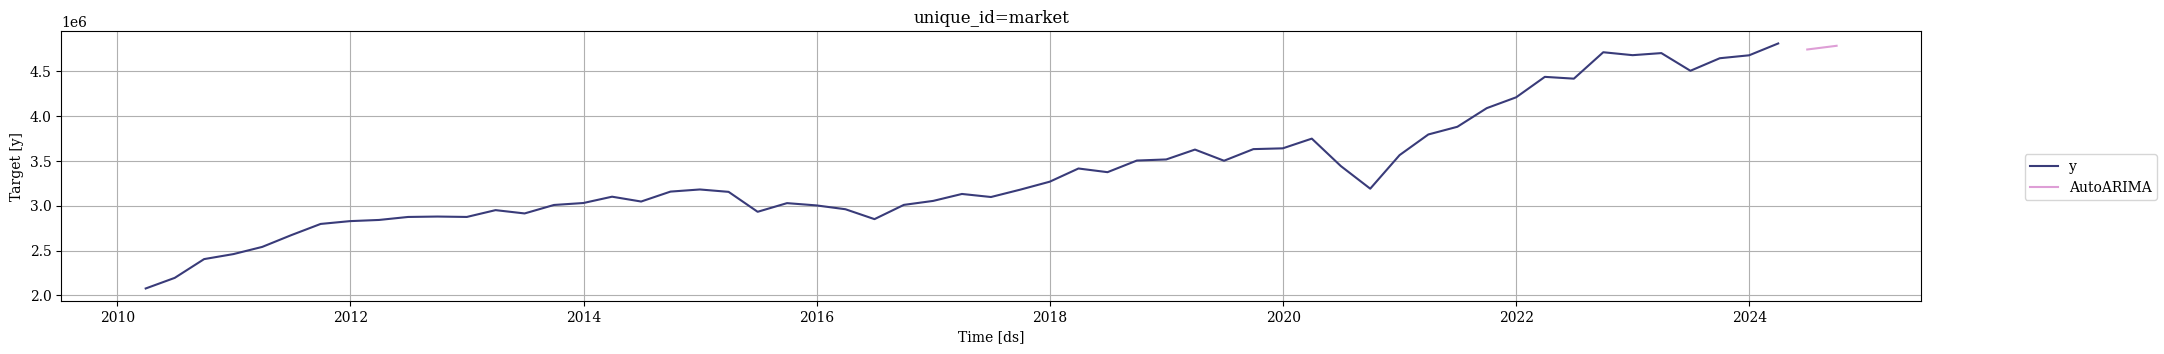

In [208]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA"],
    unique_ids=["market"],
)

## Hierarchical reconciliation

In [233]:
hrec = HierarchicalReconciliation(
    reconcilers=[
        BottomUp(),
     #   MinTrace(method="mint_shrink"),
        MinTrace(method="ols"),
        TopDown(method='forecast_proportions'),
        OptimalCombination(method='ols')
    ]
)

In [234]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [226]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

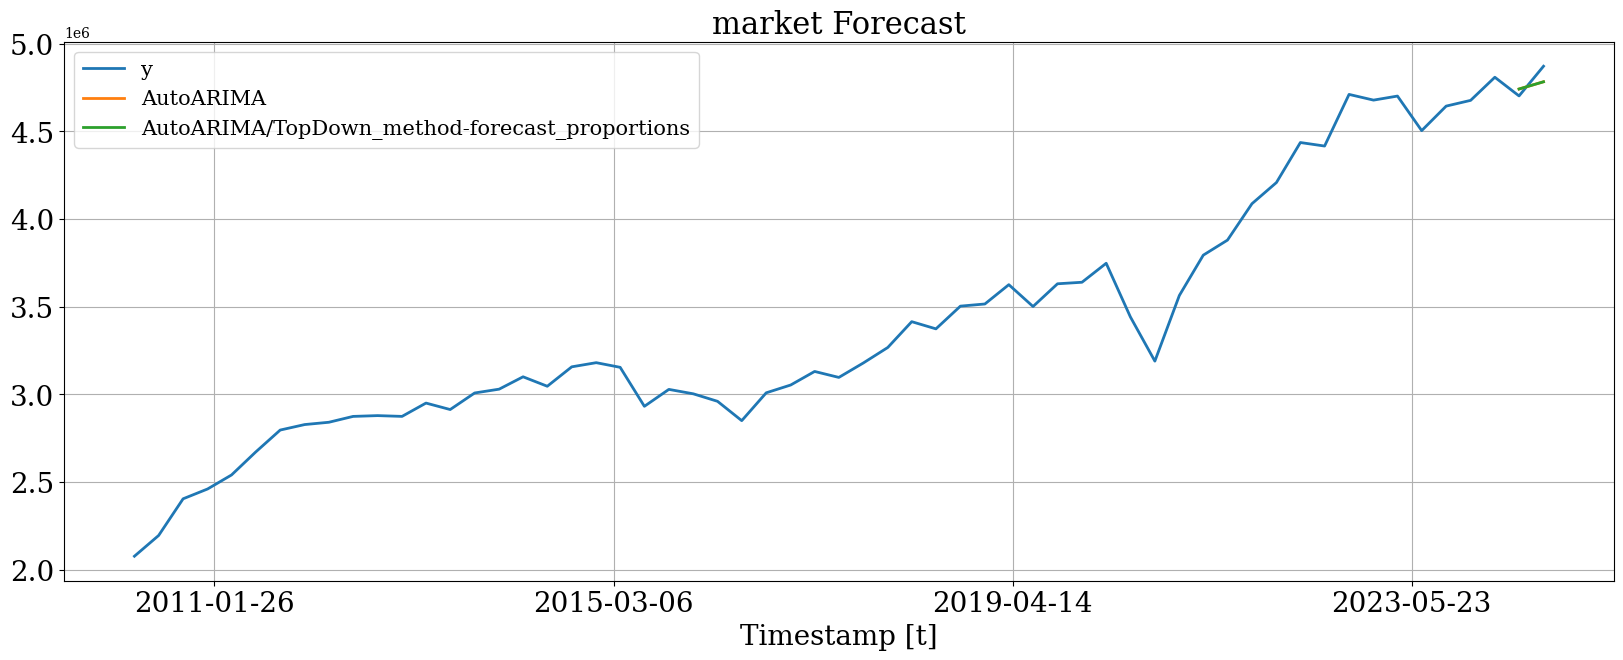

In [227]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_series(
    series="market",
    Y_df=plot_df,
    models=[
        "y",
        "AutoARIMA",
        "AutoARIMA/TopDown_method-forecast_proportions",
    ],
    level=[80],
)

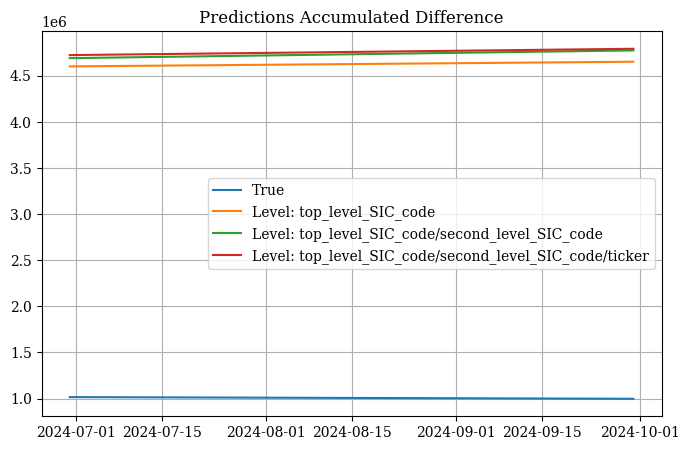

In [55]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
difference_df = Y_hat_df.merge(Y_test_df, on=["unique_id", "ds"])[
    ["ds", "AutoARIMA", "y"]
]

# hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

hplot.plot_hierarchical_predictions_gap(difference_df)

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [235]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    tags=tags,
    benchmark="AutoARIMA",
)

In [236]:
evaluation.T

level,Overall,market,market/top_level_SIC_code,market/top_level_SIC_code/second_level_SIC_code,market/top_level_SIC_code/second_level_SIC_code/ticker
metric,mse-scaled,mse-scaled,mse-scaled,mse-scaled,mse-scaled
AutoARIMA,1.0,1.0,1.0,1.0,1.0
AutoARIMA/BottomUp,0.33766,0.700817,0.177929,0.876388,1.0
AutoARIMA/MinTrace_method-ols,0.904598,1.173429,0.780557,1.535135,1.088426
AutoARIMA/TopDown_method-forecast_proportions,1.108331,1.0,0.905617,2.983127,1.583234
AutoARIMA/OptimalCombination_method-ols,0.904598,1.173429,0.780557,1.535135,1.088426


In [229]:
show_grid(
    Y_rec_df.set_index(["ds"], append=True)
    .sub(Y_test_df.set_index(["ds"], append=True)["y"], axis="index")[
        ["AutoARIMA", "AutoARIMA/TopDown_method-forecast_proportions"]
    ]
    .query('ds == "2024-06-30"')
)

C:\Users\andre\AppData\Local\Temp\ipykernel_1128\141917388.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query('ds == "2024-06-30"')


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…